In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),])
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


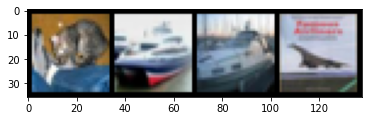

GroundTruth:    cat  ship  ship plane


In [3]:

def imshow(img, transpose = True):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
images[0].shape

torch.Size([3, 32, 32])

In [5]:
torch.tensor([3,5,5])

tensor([3, 5, 5])

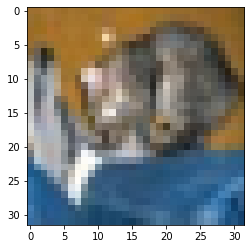

In [6]:
my_img = np.transpose(images[0].numpy(), (1, 2, 0))

plt.imshow(my_img)

In [7]:
my_img.max(),my_img.min()

(1.0, 0.050980393)

In [8]:
from captum.attr import Occlusion
from torch import Tensor
from typing import Any, Callable, Tuple, Union

In [9]:
 def occlusion_mask(
        expanded_input: Tensor,
        ablated_feature_num: int,
        sliding_window_tsr: Tensor,
        strides: Union[int, Tuple[int, ...]],
        shift_counts: Tuple[int, ...],
    ) -> Tensor:
        """
        This constructs the current occlusion mask, which is the appropriate
        shift of the sliding window tensor based on the ablated feature number.
        The feature number ranges between 0 and the product of the shift counts
        (# of times the sliding window should be shifted in each dimension).

        First, the ablated feature number is converted to the number of steps in
        each dimension from the origin, based on shift counts. This procedure
        is similar to a base conversion, with the position values equal to shift
        counts. The feature number is first taken modulo shift_counts[0] to
        get the number of shifts in the first dimension (each shift
        by shift_count[0]), and then divided by shift_count[0].
        The procedure is then continued for each element of shift_count. This
        computes the total shift in each direction for the sliding window.

        We then need to compute the padding required after the window in each
        dimension, which is equal to the total input dimension minus the sliding
        window dimension minus the (left) shift amount. We construct the
        array pad_values which contains the left and right pad values for each
        dimension, in reverse order of dimensions, starting from the last one.

        Once these padding values are computed, we pad the sliding window tensor
        of 1s with 0s appropriately, which is the corresponding mask,
        and the result will match the input shape.
        """
        remaining_total = ablated_feature_num
        current_index = []
        for i, shift_count in enumerate(shift_counts):
            stride = strides[i] if isinstance(strides, tuple) else strides
            current_index.append((remaining_total % shift_count) * stride)
            remaining_total = remaining_total // shift_count

        remaining_padding = np.subtract(
            expanded_input.shape[2:], np.add(current_index, sliding_window_tsr.shape)
        )
        pad_values = [
            val for pair in zip(remaining_padding, current_index) for val in pair
        ]
        pad_values.reverse()
        padded_tensor = torch.nn.functional.pad(
            sliding_window_tsr, tuple(pad_values)  # type: ignore
        )
        return padded_tensor.reshape((1,) + padded_tensor.shape)

In [10]:
# occlusion = Occlusion(model)

# attributions_occ = occlusion.attribute(input,
#                                        strides = (3, 50, 50),
#                                        target=pred_label_idx,
#                                        sliding_window_shapes=(3,60, 60),
#                                        baselines=0)

# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       ["original_image", "heat_map"],
#                                       ["all", "positive"],
#                                       show_colorbar=True,
#                                       outlier_perc=2,
#                                      )


In [11]:
occlu = occlusion_mask(images[0],3,torch.tensor([3,5,5]), (3,15,15), (3,3))

AssertionError: Padding length too large

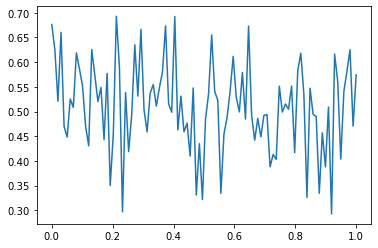

In [12]:
noise1D = np.random.normal(0.5, 0.1, 100)
xx = np.linspace(0,1,100)
plt.plot(xx,noise1D)

(array([ 5.,  3.,  5.,  9., 17., 20., 16., 10.,  7.,  8.]),
 array([0.29259943, 0.33263937, 0.37267931, 0.41271925, 0.45275919,
        0.49279913, 0.53283906, 0.572879  , 0.61291894, 0.65295888,
        0.69299882]),
 <BarContainer object of 10 artists>)

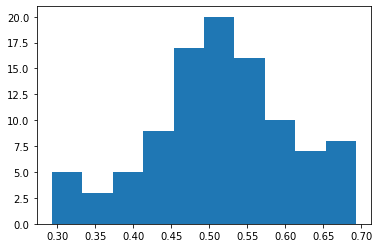

In [13]:
plt.hist(noise1D)

In [14]:
my_img.shape[:2]

(32, 32)

In [15]:
noise = np.random.normal(-0.5, 0.01, my_img.shape[:2])
noise.max(),noise.min(), noise.shape

(-0.4628852548040687, -0.5428375298529793, (32, 32))

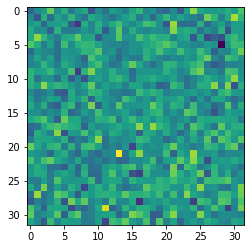

In [16]:
plt.imshow(noise)

In [17]:
noise3 = np.expand_dims(noise, axis=2)
new_noise = np.append(noise3, noise3, axis=2)
final_noise = np.append(new_noise,noise3, axis=2)

In [18]:
noise3.shape, new_noise.shape, final_noise.shape

((32, 32, 1), (32, 32, 2), (32, 32, 3))

In [19]:
final_noise[:,:,0]==final_noise[:,:,1]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [20]:
# def add_gaussian_noise(image, mean=0.5, std=0.1):
#     """
#     Args:
#         image : numpy array of image
#         mean : pixel mean of image
#         standard deviation : pixel standard deviation of image
#     Return :
#         image : numpy array of image with gaussian noise added
#     """
#     gaus_noise = np.random.normal(mean, std, image.shape)
# #     image = image.astype("int16")
#     noise_img = image + gaus_noise
#     return noise_img 

In [21]:
# new_img = add_gaussian_noise(my_img)

# plt.imshow(new_img)

In [22]:
tweaked_image = my_img + final_noise
tweaked_image.min(), tweaked_image.max(), tweaked_image.shape

(-0.4568769032678023, 0.5007822304655902, (32, 32, 3))

In [23]:
tweaked = np.where(tweaked_image < 0, 0, tweaked_image)
tweaked.min(), tweaked.max(), tweaked.shape

(0.0, 0.5007822304655902, (32, 32, 3))

In [24]:
tweaked_image.shape

(32, 32, 3)

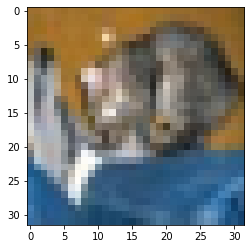

In [25]:
imshow(images[0])

In [26]:
images[0].min(), images[0].max(), images[0].shape

(tensor(0.0510), tensor(1.), torch.Size([3, 32, 32]))

In [27]:
tweaked_tensor = transform(tweaked)
tweaked_tensor.min(), tweaked_tensor.max(), tweaked_tensor.shape

(tensor(0., dtype=torch.float64),
 tensor(0.5008, dtype=torch.float64),
 torch.Size([3, 32, 32]))

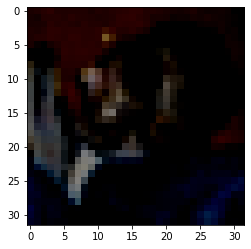

In [28]:
imshow(tweaked_tensor)

In [29]:
for i in range(4):
    print(i)

0
1
2
3


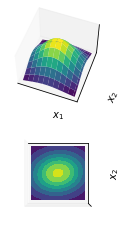

deformation maxi: 0.4349739874532734
sigX 0.47915814745620644
sigY 0.2796276740062898
cov 0.028945446080960904


In [299]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import random

# Our 2-dimensional distribution will be over variables X and Y
N = 32 #40
# r1 = [random.uniform(1, 3) for _ in range(4)]
X = np.linspace(-1, 1, N) #np.linspace(-r1[0], r1[1], N) #np.linspace(-2, 2, N)
Y = np.linspace(-1, 1, N) #np.linspace(-r1[2], r1[3], N) #np.linspace(-2, 2, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
muxy = [random.randint(-1, 1) for _ in range(2)]
mu = np.array([muxy[0], muxy[1]]) #np.array([0., 0.])

sigxy = [random.uniform(0.1, 0.5) for _ in range(2)]
cov = random.uniform(0, 0.1)
while sigxy[0]*sigxy[1]<cov**2 :
    sigxy = [random.uniform(0.1, 0.5) for _ in range(2)]
    cov = random.uniform(0, 0.1)
    
Sigma = np.array([[ sigxy[0] , cov], [cov,  sigxy[1]]]) #np.array([[ 1. , -0.5], [-0.5,  1.]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# plot using subplots
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1,projection='3d')

ax1.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)
ax1.view_init(55,-70)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')

ax2 = fig.add_subplot(2,1,2,projection='3d')
ax2.contourf(X, Y, Z, zdir='z', offset=0, cmap=cm.viridis)
ax2.view_init(90, 270)

ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')

plt.show()

print("deformation maxi:",Z.max())
print("sigX",sigxy[0])
print("sigY",sigxy[1])
print("cov",cov)

0.050980393 1.0
-0.2694659300672878 0.849607337231111 (32, 32, 3)
0.0 0.849607337231111 (32, 32, 3)
tensor(0., dtype=torch.float64) tensor(0.8496, dtype=torch.float64) torch.Size([3, 32, 32])


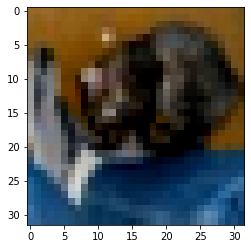

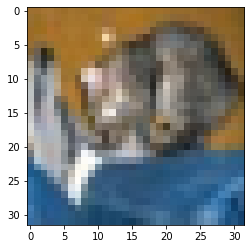

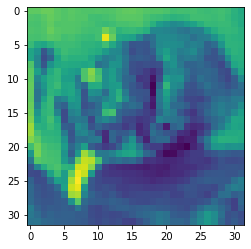

In [301]:
print(my_img.min(),my_img.max())

noise3 = np.expand_dims(Z, axis=2)
new_noise = np.append(noise3, noise3, axis=2)
final_noise = np.append(new_noise,noise3, axis=2)

tweaked_image = my_img - final_noise
print(tweaked_image.min(), tweaked_image.max(), tweaked_image.shape)

tweaked = np.where(tweaked_image < 0, 0, tweaked_image)
print(tweaked.min(), tweaked.max(), tweaked.shape)

tweaked_tensor = transform(tweaked)
print(tweaked_tensor.min(), tweaked_tensor.max(), tweaked_tensor.shape)

imshow(tweaked_tensor)
imshow(images[0])

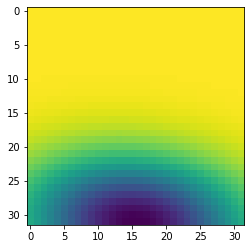

In [264]:
plt.imshow(-Z)

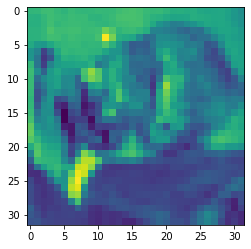

In [177]:
plt.imshow(my_img[:,:,0]-Z)

In [158]:
new_img = my_img[:,:,0]-Z
print(new_img.min(),new_img.max())

-0.12012003952733824 0.9962655081183711


In [302]:
Z

array([[0.031375  , 0.03527263, 0.03930933, ..., 0.02691752, 0.02348524,
        0.02031228],
       [0.03873215, 0.04358315, 0.0486149 , ..., 0.03411294, 0.02979011,
        0.02578866],
       [0.0471036 , 0.05305108, 0.05922948, ..., 0.04258906, 0.0372258 ,
        0.03225474],
       ...,
       [0.03225474, 0.0372258 , 0.04258906, ..., 0.05922948, 0.05305108,
        0.0471036 ],
       [0.02578866, 0.02979011, 0.03411294, ..., 0.0486149 , 0.04358315,
        0.03873215],
       [0.02031228, 0.02348524, 0.02691752, ..., 0.03930933, 0.03527263,
        0.031375  ]])